# Predicting used car price

In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
import pandas as pd

In [68]:
used_car_data = pd.read_csv('/content/drive/MyDrive/pakwheels_scrapped/pakwheels_used_car_data_v02.csv')

## Have a look at metadata

In [69]:
used_car_data.describe(include='all')

,addref,city,assembly,body,make,model,year,engine,transmission,fuel,color,registered,mileage,price
count,7.787800e+04,77878,24189,68974,77878,77878,73099.000000,77875.000000,77878,76972,76398,77878,77878.000000,7.729500e+04
unique,NaN,297,1,21,68,435,NaN,NaN,2,3,396,121,NaN,NaN
top,NaN,Lahore,Imported,Sedan,Toyota,Corolla,NaN,NaN,Automatic,Petrol,White,Islamabad,NaN,NaN
freq,NaN,16674,24189,30193,24910,12871,NaN,NaN,42763,70620,21444,18942,NaN,NaN
mean,7.809878e+06,NaN,NaN,NaN,NaN,NaN,2012.812610,1408.072550,NaN,NaN,NaN,NaN,91109.192750,3.883232e+06
std,2.599523e+05,NaN,NaN,NaN,NaN,NaN,7.516685,704.459947,NaN,NaN,NaN,NaN,89275.336173,5.759480e+06
min,2.748970e+05,NaN,NaN,NaN,NaN,NaN,1990.000000,3.000000,NaN,NaN,NaN,NaN,1.000000,1.100000e+05
25%,7.805760e+06,NaN,NaN,NaN,NaN,NaN,2007.000000,1000.000000,NaN,NaN,NaN,NaN,34000.000000,1.450000e+06
50%,7.865805e+06,NaN,NaN,NaN,NaN,NaN,2015.000000,1300.000000,NaN,NaN,NaN,NaN,80000.000000,2.700000e+06
75%,7.910334e+06,NaN,NaN,NaN,NaN,NaN,2019.000000,1600.000000,NaN,NaN,NaN,NaN,123456.000000,4.500000e+06


## Do we have missing values

In [70]:
used_car_data.isna().sum()

addref              0
city                0
assembly        53689
body             8904
make                0
model               0
year             4779
engine              3
transmission        0
fuel              906
color            1480
registered          0
mileage             0
price             583
dtype: int64

In [71]:
used_car_data['assembly'] = used_car_data['assembly'].fillna('Local')
assert used_car_data['assembly'].isna().sum() == 0

In [72]:
used_car_data[used_car_data['body'].isna()]['model'].value_counts().head(80)

Corolla    714
Civic      399
Alto       307
Prius      243
Land       240
          ... 
Acty        20
Rav4        20
Pearl       19
Town        19
Patrol      18
Name: model, Length: 80, dtype: int64

In [73]:
model_list = pd.DataFrame(used_car_data[used_car_data['body'].isna()]['model'].value_counts().head(50)).index
print('No of missing values before replacing', used_car_data['body'].isna().sum())
model_body = {}
for model in model_list:
    model_body[model] = used_car_data[used_car_data['model']==model]['body'].value_counts().idxmax()
used_car_data['body'] = used_car_data['body'].fillna(used_car_data['model'].map(model_body))
print('No of missing values after replacing', used_car_data['body'].isna().sum())

No of missing values before replacing 8904
No of missing values after replacing 2197


## Is it missing at random?

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

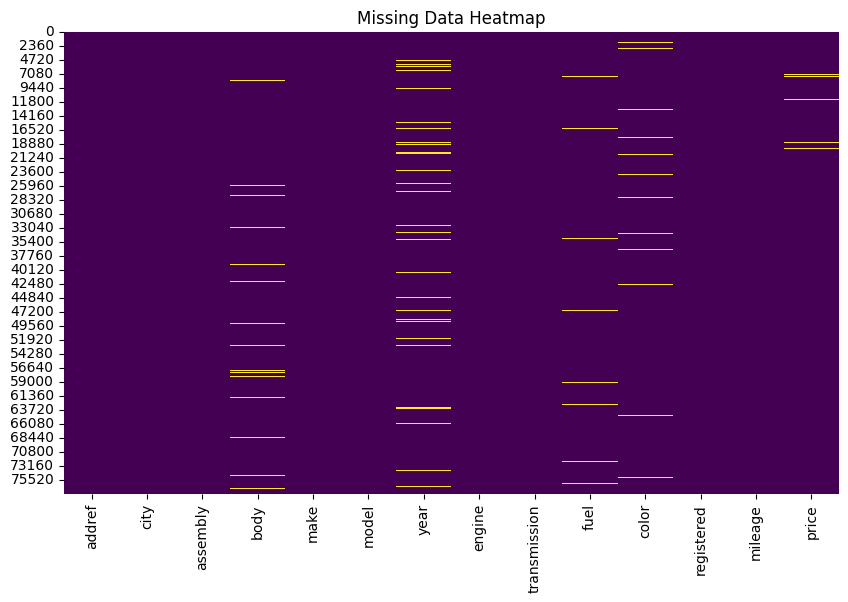

In [75]:
plt.figure(figsize=(10, 6))
sns.heatmap(used_car_data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

#### The plot shows that the data is missing at random so let work on these

In [76]:
round(used_car_data[(~used_car_data.isnull())].drop(columns=['body']).isnull().any(axis=1).sum()/used_car_data.shape[0]*100,2)

9.37

### we are going to lose approx 9.37% data if we drop rows having missing values

## Drop rows having missing data points

In [77]:
used_car_data = used_car_data.dropna()

In [78]:
used_car_data.shape

(68756, 14)

### feature engineering

In [79]:
color = ["white", "black", "gray", "grey", "silver", "red", "blue", "green", "brown", "yellow", "orange", "gold", "beige", "bronze", "titanium", "maroon"]
def color_change(color_row):
    for col in color:
        if col in color_row.lower():
            return col.capitalize()
    return color_row.capitalize()
used_car_data['color'] = used_car_data['color'].apply(lambda x: color_change(x))
used_car_data['color'] = used_car_data['color'].replace(['Night blacl', 'Timeless back', 'Galaxy balck'], 'Black')
used_car_data['color'] = used_car_data['color'].replace(['Gray', 'Gun metallic'], 'Grey')
used_car_data['color'] = used_car_data['color'].replace('Rio tomato', 'Red')
used_car_data['color'] = used_car_data['color'].replace('Yellow', 'Gold')
used_car_data['color'] = used_car_data['color'].replace(['Alpine whire', 'Whitw', 'Precious wite pearl', 'Moonstone metallic'], 'White')
used_car_data['color'].nunique()


45

## Removing outliers and unimportant features

In [80]:
ambigous_index = list(used_car_data[(used_car_data['mileage']<10000)&(used_car_data['year']<2000)].index)
ind = list(used_car_data[(used_car_data['engine']<600)|(used_car_data['engine']>6600)].index)
ambigous_index = ambigous_index + ind + [17405, 46696, 210, 2113, 197, 1649, 646, 4071, 56430]

In [81]:
import numpy as np

In [82]:
ambigous_index = np.array(ambigous_index).ravel().reshape(552,)
ambigous_index.shape

(552,)

In [83]:
to_be_dropped = used_car_data.loc[ambigous_index]

In [84]:
used_car_data = used_car_data[~used_car_data['addref'].isin(to_be_dropped['addref'])]

In [85]:
used_car_data = used_car_data.drop(columns=['addref', 'city', 'year', 'body'])
used_car_data.head()

,assembly,make,model,engine,transmission,fuel,color,registered,mileage,price
0,Local,Toyota,Corolla,1300.0,Manual,Petrol,Silver,Lahore,145000,2870000.0
1,Local,Honda,City,1300.0,Manual,Petrol,Blue,Lahore,230000,995000.0
2,Local,Toyota,Yaris,1300.0,Manual,Petrol,White,Punjab,60500,3585000.0
3,Local,Suzuki,Swift,1300.0,Manual,Petrol,Grey,Islamabad,87000,2250000.0
4,Local,Honda,Civic,1800.0,Automatic,Petrol,Grey,Lahore,86000,4850000.0


In [86]:
used_car_data.shape

(68210, 10)

## Importing python packages for ML

In [87]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from math import sqrt

### Label encoding of categorical variables

In [88]:
label_mappings = {}
categorical_columns = ['assembly', 'make', 'model', 'transmission', 'fuel', 'color', 'registered']
for col in categorical_columns:
    label_encoder = LabelEncoder()
    used_car_data[col] = label_encoder.fit_transform(used_car_data[col])
    # Store the mapping in the dictionary
    label_mappings[col] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print(label_mappings)

{'assembly': {'Imported': 0, 'Local': 1}, 'make': {'Adam': 0, 'Audi': 1, 'BAIC': 2, 'BMW': 3, 'Bentley': 4, 'Buick': 5, 'Changan': 6, 'Chery': 7, 'Chevrolet': 8, 'DFSK': 9, 'Daehan': 10, 'Daewoo': 11, 'Daihatsu': 12, 'Dodge': 13, 'FAW': 14, 'Fiat': 15, 'Ford': 16, 'GMC': 17, 'Haval': 18, 'Honda': 19, 'Hummer': 20, 'Hyundai': 21, 'Isuzu': 22, 'JAC': 23, 'JW': 24, 'Jeep': 25, 'KIA': 26, 'Land': 27, 'Lexus': 28, 'MG': 29, 'MINI': 30, 'Mazda': 31, 'Mercedes': 32, 'Mitsubishi': 33, 'Mushtaq': 34, 'Nissan': 35, 'Peugeot': 36, 'Porsche': 37, 'Prince': 38, 'Proton': 39, 'Range': 40, 'Sogo': 41, 'SsangYong': 42, 'Subaru': 43, 'Suzuki': 44, 'Toyota': 45, 'United': 46, 'Volkswagen': 47, 'Volvo': 48, 'ZOTYE': 49}, 'model': {'2': 0, '2008': 1, '3': 2, '370Z': 3, '5': 4, '7': 5, 'A3': 6, 'A4': 7, 'A5': 8, 'A6': 9, 'A7': 10, 'A8': 11, 'A800': 12, 'AD': 13, 'APV': 14, 'Accord': 15, 'Acty': 16, 'Airwave': 17, 'Allion': 18, 'Alpha': 19, 'Alphard': 20, 'Alsvin': 21, 'Altezza': 22, 'Alto': 23, 'Amarok': 2

In [89]:
decoded_make = label_mappings['make']['Honda']
print("Decoded 'make' value:", decoded_make)

Decoded 'make' value: 19


In [98]:
encoded_make = 19
decoded_make = next((key for key, value in label_mappings['make'].items() if value == encoded_make), "Unknown")
print("Decoded 'make' value:", decoded_make)

Decoded 'make' value: Honda


In [91]:
used_car_data.sample(4)

,assembly,make,model,engine,transmission,fuel,color,registered,mileage,price
62741,0,45,76,1500.0,0,2,43,36,143000,2900000.0
65465,1,44,163,796.0,1,2,19,36,100000,900000.0
5619,1,44,23,660.0,1,2,39,90,28300,2200000.0
4696,1,45,76,1300.0,1,2,43,90,79000,3450000.0


## Train Test Split

In [92]:
X = used_car_data.drop(columns=['price'])
y = used_car_data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #ratio of 70Tr/30T

## Random forest

### n_estimators = 35 gives the best r2_score (Hyper parameter tunning)

---



In [93]:
random_forest_model = RandomForestRegressor(n_estimators=35, max_depth=15, min_samples_leaf=1, min_samples_split=4, random_state=42)
random_forest_model.fit(X_train, y_train)
y_pred = random_forest_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred)
r2_rf = r2_score(y_test, y_pred)
print("Random Forest Metrics:")
print("Mean Squared Error:", mse_rf)
print("R-squared:", round(r2_rf*100, 2))

Random Forest Metrics:
Mean Squared Error: 3249150313412.395
R-squared: 86.29


In [94]:
X_test.shape

(20463, 9)

In [95]:
your_input = np.array([[1,45,76,1798,0,2,43,36,83000]])
your_predictions = random_forest_model.predict(your_input)
print("Your Predictions: RS", int(your_predictions),"/-")

Your Predictions: RS 5044661 /-


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


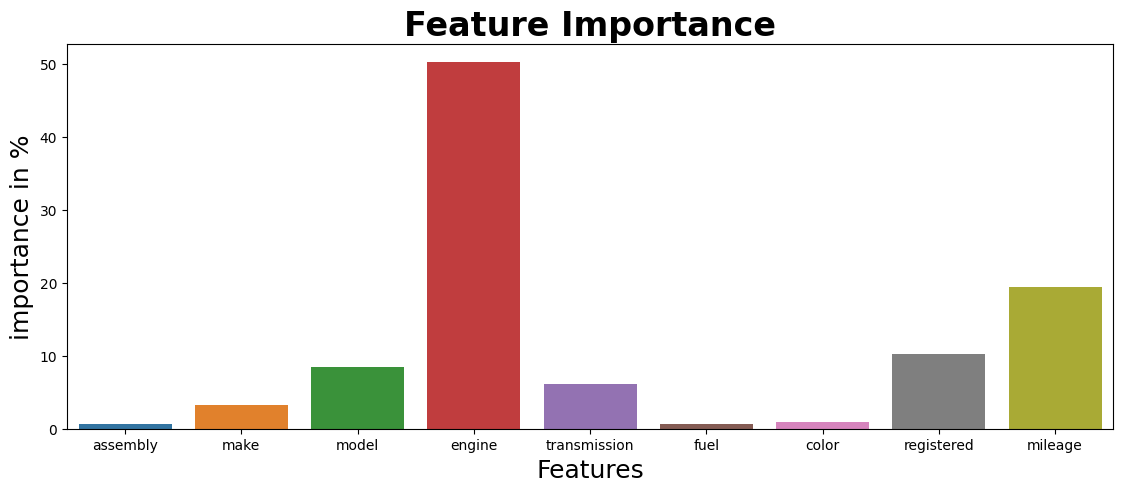

In [96]:
feature_importances = random_forest_model.feature_importances_ #Map out the important features of a dataset
plt.figure(figsize=(13.5,5))
sns.barplot(x=X.columns, y=(feature_importances*100))
plt.xlabel("Features", fontdict={'fontsize':18})
plt.ylabel("importance in %", fontdict={'fontsize':18})
plt.title("Feature Importance", fontdict={'fontsize':24, 'weight':'bold'})
plt.show()

In [97]:
import pickle

with open('PPM_by_rforestr.pkl', 'wb') as file:
    pickle.dump(random_forest_model, file)